In [39]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# plt.style.use('ggplot')

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [40]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


In [41]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Status

In [42]:
removals = df['R-T'] == 'R'
transfers = df['R-T'] == 'T'

In [43]:
status_count = df[removals].drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [44]:
status = pd.read_csv('../../../share/resources/status.csv')

In [45]:
valid_status_codes = list(status['Code'])

In [46]:
status_dict = dict(zip(status['Code'], status['Status']))

In [47]:
pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
problematic = pending + benefit + expedited_admin_rein

In [48]:
problematic_count = 0
valid = df[removals]['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~df[removals]['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'ICE Air - All removals')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
        
assert sum(df[removals]['Status'].isin(problematic)) == problematic_count
print()
print(f'{problematic_count} total problematic cases.')
print(f"{sum(df.loc[removals, 'Status'].isin(pending))} with pending appeals.")
print(f"{sum(df.loc[removals, 'Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(df.loc[removals, 'Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.")

ICE Air - All removals

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

839344 valid values.
394568 invalid values.

[1A]: 55104 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 284 (Voluntary Departure - Extended Departure Period)
[1C]: 8 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *2223* (Deportable – Under Adjudication by IJ)
[2B]: *96* (Deportable – Under Adjudication by BIA)
[3]: 20572 (Deportable – Administratively Final Order)
[5A]: 14 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 797 (Removable – ICE Fugitive)
[5C]: *16* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *86* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 32 (Relief Granted – Extended Voluntary Departure)
[5F]: 57 (Unable to Obtain Travel Document)
[8A]: *1489* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *4080* (Excluda

In [49]:
sum(df[removals]['Status'].isin(expedited_admin_rein))

627694

In [50]:
invalid_status = df[~df['Status'].isin(valid_status_codes)]
invalid_status_counts = invalid_status['Status'].value_counts()
# bad_statuses = list(status_counts[status_counts > 0].index)

In [51]:
invalid_status_counts.head(25)

REMOVAL           231309
RM                164378
NO STATUS          50831
NTA                20931
TRANSFER - F/O     19507
TRANSFER - NTA      9795
REINSTATE           6819
ER-TRANSFER         5917
STAGER              4771
NTA - TRANSFER      3036
F/O - TRANSFER      2620
TRANSFER            2174
REINST              1800
TRANSFER-NTA        1468
WD                  1030
FINAL ORDER          909
JUVI                 845
1/15/1900            747
NTA-TRANSFER         680
WA/NTA               666
NTA-TRFD             663
V/R                  635
DEPORT               584
REIN                 569
RE-INSTATE           484
Name: Status, dtype: int64

## Status by FY for removals & transfers

In [52]:
status_fy = df[removals].drop_duplicates(subset='AlienMasterID').resample('AS-OCT', on='MissionDate')['Status'].value_counts().unstack()

In [53]:
total = df[removals].drop_duplicates(subset='AlienMasterID').resample('AS-OCT', on='MissionDate')['AlienMasterID'].nunique()

In [54]:
status_fy[expedited_admin_rein]

Status,8F,8G,8H,8I,11,16
MissionDate,,,,,,
2010-10-01,9899.0,1.0,NaN,NaN,174.0,6484.0
2011-10-01,22038.0,NaN,NaN,NaN,92.0,13747.0
2012-10-01,52132.0,462.0,9.0,5.0,2298.0,45536.0
2013-10-01,53894.0,2556.0,164.0,33.0,3008.0,50542.0
2014-10-01,32056.0,4049.0,61.0,80.0,3832.0,40019.0
2015-10-01,29940.0,10335.0,246.0,128.0,3741.0,42121.0
2016-10-01,26146.0,13062.0,1264.0,214.0,2913.0,41956.0
2017-10-01,32839.0,12492.0,349.0,276.0,2652.0,45714.0
2018-10-01,6290.0,2686.0,38.0,45.0,399.0,8677.0


In [55]:
# status_fy[valid_status_codes].to_csv('../output/valid_status_by_year.csv')

In [56]:
all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

In [57]:
status_table = pd.concat([status_fy[valid_status_codes], all_others], axis=1).T

In [58]:
status_table

MissionDate,2010-10-01 00:00:00,2011-10-01 00:00:00,2012-10-01 00:00:00,2013-10-01 00:00:00,2014-10-01 00:00:00,2015-10-01 00:00:00,2016-10-01 00:00:00,2017-10-01 00:00:00,2018-10-01 00:00:00
1A,22425.0,22071.0,9738.0,513.0,264.0,36.0,23.0,27.0,7.0
1B,NaN,NaN,112.0,93.0,72.0,1.0,1.0,4.0,1.0
1C,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN
2A,NaN,NaN,994.0,233.0,301.0,106.0,217.0,325.0,47.0
2B,NaN,NaN,15.0,13.0,11.0,15.0,24.0,15.0,3.0
3,1149.0,555.0,1281.0,1737.0,2645.0,3354.0,4033.0,4953.0,865.0
5A,NaN,NaN,2.0,4.0,3.0,NaN,2.0,2.0,1.0
5B,NaN,NaN,68.0,241.0,141.0,65.0,133.0,137.0,12.0
5C,NaN,NaN,1.0,4.0,4.0,1.0,2.0,3.0,1.0
5D,NaN,NaN,16.0,18.0,8.0,4.0,19.0,17.0,4.0


In [59]:
# status_table.to_csv('../output/removal_status_by_year.csv')
# (status_table/total).to_csv('../output/removal_status_by_year_percent.csv')

## Status for specific airport

In [78]:
airport = 'KCSG'

In [79]:
airport_name = airport_dict[airport]
pickups = df['PULOC'] == airport
dropoffs = df['DropLoc'] == airport
airport_df = df[pickups|dropoffs]

In [80]:
removals = airport_df['R-T'] == 'R'
transfers = airport_df['R-T'] == 'T'

In [81]:
status_count = airport_df[removals].drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)
count = 0
problematic_count = 0
valid = airport_df[removals]['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~airport_df[removals]['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'ICE Air - {airport} removals')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
        
assert sum(airport_df[removals]['Status'].isin(problematic)) == problematic_count
print()
print(f'{problematic_count} total problematic cases.')
print(f"{sum(airport_df.loc[removals, 'Status'].isin(pending))} with pending appeals.")
print(f"{sum(airport_df.loc[removals, 'Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(airport_df.loc[removals, 'Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.")

ICE Air - KCSG removals

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

32572 valid values.
28384 invalid values.

[1A]: 2458 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 30 (Voluntary Departure - Extended Departure Period)
[1C]: 2 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *73* (Deportable – Under Adjudication by IJ)
[2B]: *0* (Deportable – Under Adjudication by BIA)
[3]: 763 (Deportable – Administratively Final Order)
[5A]: 1 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 23 (Removable – ICE Fugitive)
[5C]: *0* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *1* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 0 (Relief Granted – Extended Voluntary Departure)
[5F]: 1 (Unable to Obtain Travel Document)
[8A]: *73* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *333* (Excludable/Inadmissible 

In [69]:
airport_df[transfers]['Status'].value_counts().head(23)

8G                526
16                336
8C                336
STAGER            319
8F                225
TRANSFER - F/O    222
3                 200
TRANSFER           80
REMOVAL            53
STAGERS            51
8E                 30
8A                 27
8I                 19
8B                 19
TRANSFER/ETW       18
11                 15
FO TRANSFER        11
WA/NTA             10
2A                  8
5B                  7
5F                  7
TRANSFER F/O        6
RM                  6
Name: Status, dtype: int64

In [71]:
sum(airport_df[transfers]['Status'].isin(expedited_admin_rein))

1126

In [72]:
sum(airport_df[transfers]['Status'].isin(pending))

58

In [73]:
sum(airport_df[transfers]['Status'].isin(benefit))

0

# Status for specific nationality

In [27]:
nationality = 'CAMBODIA'

errormsg = f'{nationality} not represented in dataset'
assert nationality.upper() in df['CountryOfCitizenship'].str.upper().unique(), errormsg

nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

removals = nationality_df['R-T'] == 'R'
transfers = nationality_df['R-T'] == 'T'

In [28]:
status_count = nationality_df[removals].drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)
count = 0
problematic_count = 0
valid = nationality_df[removals]['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~nationality_df[removals]['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'ICE Air - {nationality} removals')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
        
assert sum(nationality_df[removals]['Status'].isin(problematic)) == problematic_count
print()
print(f'{problematic_count} total problematic cases.')
print(f"{sum(nationality_df.loc[removals, 'Status'].isin(pending))} with pending appeals.")
print(f"{sum(nationality_df.loc[removals, 'Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(nationality_df.loc[removals, 'Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.")

ICE Air - CAMBODIA removals

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

120 valid values.
0 invalid values.

[1A]: 0 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 0 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *0* (Deportable – Under Adjudication by IJ)
[2B]: *0* (Deportable – Under Adjudication by BIA)
[3]: 105 (Deportable – Administratively Final Order)
[5A]: 0 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 2 (Removable – ICE Fugitive)
[5C]: *0* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *0* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 0 (Relief Granted – Extended Voluntary Departure)
[5F]: 5 (Unable to Obtain Travel Document)
[8A]: *0* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *0* (Excludable/Inadmissible – Under Adj

In [29]:
pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']

In [30]:
sum(nationality_df.loc[removals, 'Status'].isin(pending))

0

In [31]:
sum(nationality_df.loc[removals, 'Status'].isin(benefit))

0

In [32]:
sum(nationality_df.loc[removals, 'Status'].isin(expedited_admin_rein))

1

In [33]:
invalid_status = nationality_df[~nationality_df['Status'].isin(valid_status_codes)]
invalid_status_counts = invalid_status['Status'].value_counts()
# bad_statuses = list(status_counts[status_counts > 0].index)

In [34]:
invalid_status_counts.head(10)

TRANSFER - F/O    143
TRANSFER           67
TRANSFER - NTA     40
NO STATUS          39
REMOVAL            33
NTA                10
F/O - TRANSFER      7
STAGING             4
INTERVIEW           2
RR - TRANSFER       2
Name: Status, dtype: int64

# Status by AOR

In [35]:
df.columns

Index(['Status', 'Sex', 'Convictions', 'GangMember', 'ClassLvl', 'Age',
       'MissionDate', 'MissionNumber', 'PULOC', 'DropLoc', 'StrikeFromList',
       'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship', 'Juvenile',
       'MissionWeek', 'MissionQuarter', 'MissionYear', 'MissionMonth',
       'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag', 'AlienMasterID',
       'MissionID', 'air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'air_LatitudeDecimalDegrees',
       'air_LongitudeDecimalDegrees', 'air2_LatitudeDecimalDegrees',
       'air2_LongitudeDecimalDegrees', 'NonCriminal'],
      dtype='object')

In [36]:
removals = df['R-T'] == 'R'
transfers = df['R-T'] == 'T'

In [37]:
df[removals].groupby(['AOR_AORID'])['Status'].value_counts()

AOR_AORID  Status        
1.0        RM                19893
           8C                14129
           16                13212
           REMOVAL           11960
           1A                 3311
           8F                 3035
           11                 2612
           12                 2051
           8G                 1507
           3                  1038
           NO STATUS           394
           8B                  342
           8H                  274
           9                   235
           8E                  219
           TRANSFER - F/O      151
           1/15/1900           127
           2A                   93
           8A                   73
           ROMOVAL              59
           TRANSFER             56
           8I                   47
           1B                   39
           1/10/1900            29
           1/11/1900            29
           5B                   27
           1/2/1900              7
           13                

In [38]:
aor = 22

In [39]:
aor_df = df[df['AOR_AORID'] == aor]

In [40]:
aor_df['Status'].value_counts().head(10)

REMOVAL           8206
16                6846
8C                4762
1A                2810
8F                2398
TRANSFER - F/O    2031
8G                1730
12                1363
11                1278
RM                 744
Name: Status, dtype: int64

In [41]:
status_count = aor_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)
count = 0
problematic_count = 0
valid = aor_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~aor_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'ICE Air - AOR {aor} removals')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
        
assert sum(aor_df.loc[:, 'Status'].isin(problematic)) == problematic_count
print()
print(f'{problematic_count} total problematic cases.')
print(f"{sum(aor_df.loc[:, 'Status'].isin(pending))} with pending appeals.")
print(f"{sum(aor_df.loc[:, 'Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(aor_df.loc[:, 'Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.") 

ICE Air - AOR 22 removals

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

23445 valid values.
11317 invalid values.

[1A]: 2810 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 100 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *335* (Deportable – Under Adjudication by IJ)
[2B]: *12* (Deportable – Under Adjudication by BIA)
[3]: 633 (Deportable – Administratively Final Order)
[5A]: 29 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 93 (Removable – ICE Fugitive)
[5C]: *3* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *2* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 2 (Relief Granted – Extended Voluntary Departure)
[5F]: 13 (Unable to Obtain Travel Document)
[8A]: *102* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *283* (Excludable/Inadm

In [62]:
aor_df['MissionDate'].describe()

count                   34762
unique                    469
top       2016-12-11 00:00:00
freq                      135
first     2010-10-02 00:00:00
last      2018-12-04 00:00:00
Name: MissionDate, dtype: object

In [42]:
aor_df[valid]['Status'].value_counts().head(28)

16    6846
8C    4762
1A    2810
8F    2398
8G    1730
12    1363
11    1278
3      633
9      351
2A     335
8B     283
8E     175
8A     102
1B     100
5B      93
8I      70
5A      29
8D      27
8H      19
5F      13
2B      12
10       6
5C       3
5D       2
5E       2
13       1
14       1
15       1
Name: Status, dtype: int64

In [43]:
arts_count = aor_df[valid]['Status'].value_counts().head(28)

# ICE Seattle AOR removals

In [44]:
seattle_er = pd.read_csv('../frozen/SeattleAORExpeditedRemovals.csv', header=6)
seattle_or = pd.read_csv('../frozen/SeattleAOROtherRemovals.csv', header=6)

In [45]:
seattle_er.head()

,Departed Date,Date of Birth,Gender,Country of Citizenship,Event Number,Most Serious Conviction,Case Category
0,1/3/2012,"(b)(6),(b)(7)(c )",Male,FRANCE,(b)(7)(E ),NaN,[8F] Expedited Removal
1,1/5/2012,"(b)(6),(b)(7)(c )",Female,EL SALVADOR,(b)(7)(E ),NaN,[8G] Expedited Removal - Credible Fear Referral
2,1/6/2012,"(b)(6),(b)(7)(c )",Female,BELIZE,(b)(7)(E ),NaN,[8F] Expedited Removal
3,1/11/2012,"(b)(6),(b)(7)(c )",Female,EL SALVADOR,(b)(7)(E ),NaN,[8G] Expedited Removal - Credible Fear Referral
4,1/11/2012,"(b)(6),(b)(7)(c )",Female,EL SALVADOR,(b)(7)(E ),NaN,[8F] Expedited Removal


In [46]:
seattle_or.head()

,Departed Date,Date of Birth,Gender,Country of Citizenship,Event Number,Most Serious Conviction,Case Category
0,1/3/2012,"(b)(6),(b)(7)(c )",Male,MEXICO,(b)(7)(E ),NaN,[8C] Excludable / Inadmissible - Administrativ...
1,1/3/2012,"(b)(6),(b)(7)(c )",Female,MEXICO,(b)(7)(E ),NaN,[3] Deportable - Administratively Final Order
2,1/4/2012,"(b)(6),(b)(7)(c )",Male,MEXICO,(b)(7)(E ),NaN,[8C] Excludable / Inadmissible - Administrativ...
3,1/4/2012,"(b)(6),(b)(7)(c )",Male,MEXICO,(b)(7)(E ),NaN,[16] Reinstated Final Order
4,1/4/2012,"(b)(6),(b)(7)(c )",Male,MEXICO,(b)(7)(E ),NaN,[16] Reinstated Final Order


In [47]:
seattle_aor = pd.concat([seattle_er, seattle_or])

In [73]:
seattle_aor['Status'] = seattle_aor['Case Category'].str.extract(pat='.*\[(.*)\].*')

In [48]:
seattle_aor['Case Category'].value_counts()

[8C] Excludable / Inadmissible - Administrative Final Order Issued        9535
[16] Reinstated Final Order                                               6866
[8F] Expedited Removal                                                    3602
[8G] Expedited Removal - Credible Fear Referral                           2865
[3] Deportable - Administratively Final Order                             1871
[11] Administrative Deportation / Removal                                  932
[9] VR Under Safeguards                                                    539
[8E] Inadmissible - ICE Fugitive                                           206
[10] Visa Waiver Deportation / Removal                                     140
[8A] Excludable / Inadmissible - Hearing Not Commenced                      86
[2A] Deportable - Under Adjudication by IJ                                  64
[5B] Removable - ICE Fugitive                                               53
[14] Crewmen, Stowaways, S-Visa Holders, 235(c) Case

In [49]:
seattle_aor['Departed Date'] = pd.to_datetime(seattle_aor['Departed Date'])

In [50]:
seattle_aor['Departed Date'].describe()

count                   26913
unique                   2195
top       2013-01-09 00:00:00
freq                      150
first     2011-11-30 00:00:00
last      2019-07-02 00:00:00
Name: Departed Date, dtype: object

In [90]:
ero_count = seattle_aor['Status'].value_counts().reset_index().set_index('index')

In [91]:
ero_count = ero_count.rename({'Status': 'ERO-LESA count'}, axis=1)

In [92]:
arts_count = arts_count.reset_index().set_index('index')

In [93]:
arts_count = arts_count.rename({'Status': 'ARTS count'}, axis=1)

In [95]:
compare = arts_count.join(ero_count)

In [96]:
compare.index.name = 'Status'

In [97]:
compare = compare.fillna(0)

In [98]:
compare['ERO-LESA count'] = compare['ERO-LESA count'].astype(int)

In [99]:
print(compare)

        ARTS count  ERO-LESA count
Status                            
16            6846            6866
8C            4762            9535
1A            2810              13
8F            2398            3602
8G            1730            2865
12            1363               3
11            1278             932
3              633            1871
9              351             539
2A             335              64
8B             283              10
8E             175             206
8A             102              86
1B             100               1
5B              93              53
8I              70              40
5A              29               0
8D              27               0
8H              19              22
5F              13               2
2B              12               4
10               6             140
5C               3               3
5D               2               2
5E               2              11
13               1               0
14               1  

In [100]:
seattle_aor.columns

Index(['Departed Date', 'Date of Birth', 'Gender', 'Country of Citizenship',
       'Event Number', 'Most Serious Conviction', 'Case Category', 'Status'],
      dtype='object')

In [103]:
seattle_aor.groupby(['Country of Citizenship'])['Status'].value_counts(normalize=True).unstack()

Status,10,11,12,14,16,1A,1B,2A,2B,3,...,5F,8A,8B,8C,8E,8F,8G,8H,8I,9
Country of Citizenship,,,,,,,,,,,,,,,,,,,,,
AFGHANISTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608696,...,NaN,NaN,NaN,0.043478,NaN,0.043478,0.130435,NaN,NaN,0.130435
ALBANIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALGERIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.500000,NaN,0.500000,NaN,NaN,NaN,NaN
ANGOLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
ANTIGUA-BARBUDA,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARGENTINA,0.153846,NaN,NaN,NaN,0.153846,NaN,NaN,NaN,NaN,0.461538,...,NaN,NaN,NaN,0.076923,NaN,0.076923,0.076923,NaN,NaN,NaN
ARMENIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.666667,NaN,NaN,0.333333,NaN,NaN,NaN
ARUBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUSTRALIA,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444,...,NaN,0.111111,NaN,0.055556,NaN,0.055556,NaN,NaN,NaN,0.055556


In [216]:
pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
expedited = ['8F', '8G', '8H', '8I']
admin = ['11']
rein = ['16']

In [217]:
seattle_aor['pending'] = seattle_aor['Status'].isin(pending)
seattle_aor['benefit'] = seattle_aor['Status'].isin(benefit)
seattle_aor['expedited_admin_rein'] = seattle_aor['Status'].isin(expedited_admin_rein)
seattle_aor['expedited'] = seattle_aor['Status'].isin(expedited)
seattle_aor['admin'] = seattle_aor['Status'].isin(admin)
seattle_aor['rein'] = seattle_aor['Status'].isin(rein)
seattle_aor['other'] = ~seattle_aor['Status'].isin(expedited_admin_rein)

In [218]:
seattle_aor.groupby(['Country of Citizenship'])['pending'].value_counts().unstack().sort_values(by=True, ascending=False).head(10)

pending,False,True
Country of Citizenship,,
CANADA,182.0,36.0
MEXICO,14833.0,30.0
"CHINA, PEOPLES REPUBLIC OF",228.0,13.0
PHILIPPINES,139.0,9.0
INDIA,224.0,6.0
SAUDI ARABIA,75.0,6.0
GERMANY,38.0,4.0
HONDURAS,2153.0,4.0
INDONESIA,27.0,4.0


In [219]:
seattle_aor.groupby(['Country of Citizenship'])['benefit'].value_counts().unstack().sort_values(by=True, ascending=False).head(10)

benefit,False,True
Country of Citizenship,,
MEXICO,14861.0,2.0
"CHINA, PEOPLES REPUBLIC OF",240.0,1.0
IRAQ,14.0,1.0
SUDAN,6.0,1.0
AFGHANISTAN,23.0,NaN
ALBANIA,3.0,NaN
ALGERIA,4.0,NaN
ANGOLA,1.0,NaN
ANTIGUA-BARBUDA,1.0,NaN


In [220]:
seattle_aor.groupby(['Country of Citizenship'])['expedited_admin_rein'].value_counts().unstack().sort_values(by=True, ascending=False).head(10)

expedited_admin_rein,False,True
Country of Citizenship,,
MEXICO,8883.0,5980.0
GUATEMALA,1000.0,2514.0
EL SALVADOR,479.0,2107.0
HONDURAS,443.0,1714.0
HAITI,10.0,602.0
INDIA,83.0,147.0
"CHINA, PEOPLES REPUBLIC OF",95.0,146.0
ECUADOR,24.0,137.0
NICARAGUA,34.0,99.0


In [221]:
seattle_aor = seattle_aor.set_index('Departed Date')

KeyError: 'Departed Date'

In [222]:
exped = seattle_aor.groupby(['Country of Citizenship'])['expedited']
admin = seattle_aor.groupby(['Country of Citizenship'])['admin']
rein = seattle_aor.groupby(['Country of Citizenship'])['rein']

In [223]:
exped_top10 = exped.value_counts().unstack().sort_values(by=True, ascending=False).head(10).index.tolist()

In [224]:
# Top 10 nationalities for number of expedited removals, sorted by proportion of expedited removals
exped.value_counts(normalize=True).unstack()[exped.value_counts(normalize=True).unstack().index.isin(exped_top10)].sort_values(by=True, ascending=False)

expedited,False,True
Country of Citizenship,,
HAITI,0.017974,0.982026
ECUADOR,0.391304,0.608696
INDIA,0.426087,0.573913
"CHINA, PEOPLES REPUBLIC OF",0.431535,0.568465
EL SALVADOR,0.467517,0.532483
BRAZIL,0.476190,0.523810
NICARAGUA,0.526316,0.473684
GUATEMALA,0.572567,0.427433
HONDURAS,0.584145,0.415855


In [225]:
# Top five nationalitites for expedited removal as percent of removals
exped.value_counts(normalize=True).unstack().sort_values(by=True, ascending=False).dropna().head(5)

expedited,False,True
Country of Citizenship,,
HAITI,0.017974,0.982026
ERITREA,0.230769,0.769231
GHANA,0.266667,0.733333
SENEGAL,0.285714,0.714286
PAKISTAN,0.294118,0.705882


In [226]:
# Bottom five nationalitites for expedited removal as percent of removals
exped.value_counts(normalize=True).unstack().sort_values(by=True, ascending=False).dropna().tail(5)

expedited,False,True
Country of Citizenship,,
NEW ZEALAND,0.944444,0.055556
AUSTRALIA,0.944444,0.055556
MARSHALL ISLANDS,0.947368,0.052632
UNITED KINGDOM,0.953125,0.046875
CAMBODIA,0.969697,0.030303


In [227]:
status_fy = seattle_aor.groupby([pd.Grouper(freq='AS-OCT')])['expedited', 'admin', 'rein', 'other']

In [228]:
status_fy.sum()

,expedited,admin,rein,other
Departed Date,,,,
2011-10-01,540.0,290.0,1351.0,2815.0
2012-10-01,804.0,273.0,1546.0,1848.0
2013-10-01,766.0,58.0,716.0,849.0
2014-10-01,574.0,40.0,484.0,624.0
2015-10-01,1052.0,38.0,415.0,603.0
2016-10-01,1148.0,125.0,822.0,1885.0
2017-10-01,820.0,80.0,842.0,2368.0
2018-10-01,825.0,28.0,690.0,1594.0


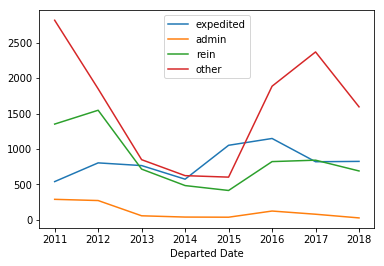

In [233]:
status_fy.sum().plot()

In [235]:
other_status = seattle_aor[seattle_aor['other'] == True]

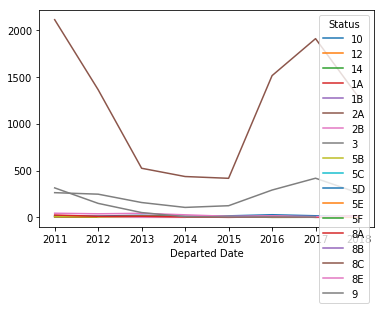

In [240]:
other_status.groupby([pd.Grouper(freq='AS-OCT')])['Status'].value_counts().unstack().plot()

In [242]:
other_status.groupby([pd.Grouper(freq='AS-OCT')])['Status'].value_counts().unstack()

Status,10,12,14,1A,1B,2A,2B,3,5B,5C,5D,5E,5F,8A,8B,8C,8E,9
Departed Date,,,,,,,,,,,,,,,,,,
2011-10-01,18.0,NaN,6.0,8.0,1.0,14.0,NaN,264.0,9.0,1.0,NaN,1.0,NaN,26.0,NaN,2107.0,45.0,315.0
2012-10-01,15.0,NaN,7.0,2.0,NaN,6.0,2.0,248.0,5.0,NaN,1.0,NaN,NaN,12.0,NaN,1361.0,39.0,150.0
2013-10-01,23.0,NaN,9.0,NaN,NaN,10.0,1.0,159.0,12.0,NaN,NaN,NaN,1.0,13.0,1.0,524.0,44.0,52.0
2014-10-01,13.0,1.0,7.0,NaN,NaN,7.0,1.0,107.0,10.0,NaN,NaN,NaN,NaN,6.0,NaN,436.0,28.0,8.0
2015-10-01,17.0,NaN,9.0,2.0,NaN,5.0,NaN,125.0,9.0,NaN,1.0,NaN,NaN,1.0,NaN,417.0,12.0,5.0
2016-10-01,29.0,NaN,1.0,NaN,NaN,14.0,NaN,292.0,5.0,NaN,NaN,2.0,1.0,7.0,1.0,1511.0,17.0,5.0
2017-10-01,18.0,2.0,2.0,NaN,NaN,1.0,NaN,418.0,2.0,2.0,NaN,2.0,NaN,3.0,NaN,1905.0,9.0,4.0
2018-10-01,7.0,NaN,2.0,1.0,NaN,7.0,NaN,258.0,1.0,NaN,NaN,6.0,NaN,18.0,8.0,1274.0,12.0,NaN


In [243]:
seattle_aor['Case Category'].unique()

array(['[8F] Expedited Removal',
       '[8G] Expedited Removal - Credible Fear Referral',
       '[8I] Inadmissible - ICE Fugitive - Expedited Removal',
       '[8H] Expedited Removal - Status Claim Referral',
       '[8C] Excludable / Inadmissible - Administrative Final Order Issued',
       '[3] Deportable - Administratively Final Order',
       '[16] Reinstated Final Order', '[9] VR Under Safeguards',
       '[11] Administrative Deportation / Removal',
       '[2A] Deportable - Under Adjudication by IJ',
       '[5B] Removable - ICE Fugitive',
       '[8E] Inadmissible - ICE Fugitive',
       '[10] Visa Waiver Deportation / Removal',
       '[8A] Excludable / Inadmissible - Hearing Not Commenced',
       '[1A] Voluntary Departure - Un-Expired and Un-Extended Departure Period',
       '[5E] Relief Granted - Extended Voluntary Departure',
       '[1B] Voluntary Departure - Extended Departure Period',
       '[14] Crewmen, Stowaways, S-Visa Holders, 235(c) Cases',
       '[5C] Relief 

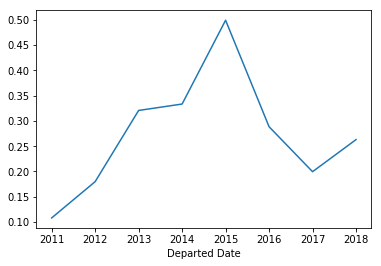

In [259]:
seattle_aor.groupby([pd.Grouper(freq='AS-OCT')])['expedited'].value_counts(normalize=True).unstack()[True].plot()

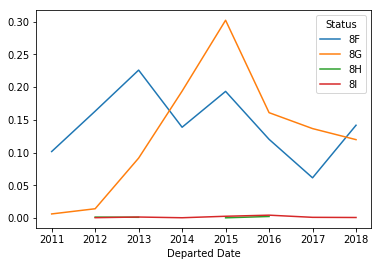

In [270]:
exped_top10seattle_aor.groupby([pd.Grouper(freq='AS-OCT')])['Status'].value_counts(normalize=True).unstack()[expedited].plot()

In [343]:
temp =seattle_aor.groupby(['Country of Citizenship'])['expedited'].sum().reset_index()

In [352]:
most_exped = list(temp[temp['expedited'] > 50]['Country of Citizenship'])

In [377]:
pct_change =  seattle_aor[seattle_aor['Country of Citizenship'].isin(most_exped)].groupby([pd.Grouper(freq='AS-OCT'), 'Country of Citizenship'])['expedited'].sum().unstack().pct_change().dropna(axis=0, how='all')

In [381]:
pct_change

Country of Citizenship,BRAZIL,"CHINA, PEOPLES REPUBLIC OF",ECUADOR,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,INDIA,MEXICO,NICARAGUA,PHILIPPINES
Departed Date,,,,,,,,,,,
2012-10-01,inf,7.333333,-0.700000,2.069444,-0.301003,NaN,2.652174,1.428571,0.531250,0.000000,1.125000
2013-10-01,-0.600000,-0.120000,1.333333,0.769231,-0.655502,NaN,-0.613095,0.117647,0.938776,2.000000,-0.470588
2014-10-01,4.500000,-0.272727,2.142857,-0.608696,0.277778,NaN,-0.169231,-0.684211,0.515789,1.833333,-0.222222
2015-10-01,-0.090909,0.187500,0.318182,0.921569,2.532609,inf,2.018519,4.000000,-0.326389,-0.411765,-0.285714
2016-10-01,0.000000,0.105263,-0.482759,-0.557823,-0.704615,564.000000,-0.441718,-0.466667,0.020619,0.200000,-0.600000
2017-10-01,0.500000,-0.047619,-0.666667,-0.484615,0.541667,-0.941593,0.186813,-0.125000,2.090909,-0.666667,-0.500000
2018-10-01,-0.866667,-0.450000,0.400000,-0.268657,0.763514,-0.939394,0.870370,0.642857,-0.320261,1.500000,1.000000
